In [1]:
import time

print 'Last update:', time.ctime(time.time())  


Last update: Tue Jan 14 17:46:14 2020


(adapted from: http://localhost:8888/notebooks/develop/SWOT/Filtering/box_filtering/2018-07-26_diff_noisesc2c6_BOX.ipynb)

# Loading the necesssary modules:

In [2]:
import numpy as np
import xarray as xr

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
%load_ext autoreload
%autoreload 2
%load_ext version_information
%version_information numpy, matplotlib, xarray, Basemap, ipykernel, jupyter, notebook

Software,Version
Python,2.7.11 64bit [GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]
IPython,5.8.0
OS,Darwin 16.7.0 x86_64 i386 64bit
numpy,1.16.4
matplotlib,2.2.2
xarray,0.10.6
Basemap,1.0.8
ipykernel,4.10.1
jupyter,1.0.0
notebook,5.7.8


# Defining the necessary functions:

In [4]:
def plot_map_p09(xx, yy, var, ax, box, vmin, vmax, merv, parv, cmap):
    """
    Plots an individual plot of the data using scatter and Basemap.
    Input variables:
    - xx = x-axis variable, in this case, longitude
    - yy = y-axis variable, in this case, latitude
    - var = variable to be plotted
    - ax = axis
    - box = box region of the area wanted to be shown
    , where box is a 1 x 4 array: 
    [minimum_longitude maximum_longitude minimum_latitude maximum_latitude]
    - vmin = minimum value of the colorbar 
    - vmax = maximum value of the colorbar
    - merv = a 1 x 4 array to know if to label and where the meridians
    -- [0 0 0 0] = no labels
    -- [1 0 0 1]
    - parv = like merv, but for the parallels' labels
    - cmap = colormap to be used
    Output variables:
    - pp = plot object
    """
    lomin = box[0]
    lomax = box[1]
    lamin = box[2]
    lamax = box[3]
    
    map = Basemap(llcrnrlon=lomin,llcrnrlat=lamin,urcrnrlon=lomax,urcrnrlat=lamax,
         resolution='i', projection='merc', lat_0 = (lamin+lamax)/2, lon_0 = (lomin+lomax)/2
                  , ax=ax, area_thresh=10)
    map.drawcoastlines()

    map.fillcontinents(color='#ddaa66')
    map.drawmeridians(np.arange(-160, 140, 1), labels=merv, size=12)
    map.drawparallels(np.arange(0.5, 70.5, 1), labels=parv, size=12)

    pp = map.scatter(xx, yy, s=2, c=var, linewidth=0, vmin=vmin, vmax=vmax, latlon=True
                     , cmap = cmap)
    pp.set_clim([vmin, vmax])
    
    return pp


In [5]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.
    Source: https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
    '''
    
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # Regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # Shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

## Loading the data:
* Specify:
    * Directory of SWOT files
    * General filename (it is important to note that it's necessary that the SWOT simulator output filenames are in the format: whatever_name_cXX_pXXX.nc)

In [6]:
datadir = '/Users/laura/PhD_private/data/SWOT_box_selections/noise/'
general_filename = 'MED_1km_nogap_JAS12_swotFastPhase_BOX_' 

## Select cycles and pass to plot:

In [7]:
ncycles = [2, 6]
npass = 9

## Loading the data:

In [8]:
for ii in xrange(0, len(ncycles)):
    ncycle = ncycles[ii]

    myfile = datadir + general_filename + 'c' + str(ncycle).zfill(2) + '_p' + str(npass).zfill(3) + '.nc'
    print myfile

    ##====================== Load SWOT data ========================

    xds = xr.open_dataset(myfile, engine='netcdf4', lock=False)
    lon = xds.lon_box
    lat = xds.lat_box
    karin = xds.karin
    roll = xds.rolle
    timerr = xds.timerr
    phas = xds.phase
    bd = xds.bd
    pd = xds.pd
    pd2b = xds.pd2b

    ##================ Converting to masked array ==================

    locals()["lon_c"+str(ncycle)] = lon.to_masked_array()
    locals()["lat_c"+str(ncycle)] = lat.to_masked_array()
    locals()["karin_c"+str(ncycle)] = karin.to_masked_array()
    locals()["roll_c"+str(ncycle)] = roll.to_masked_array()
    locals()["timerr_c"+str(ncycle)] = timerr.to_masked_array()
    locals()["phas_c"+str(ncycle)] = phas.to_masked_array()
    locals()["bd_c"+str(ncycle)] = bd.to_masked_array()
    locals()["pd_c"+str(ncycle)] = pd.to_masked_array()
    locals()["pd2b_c"+str(ncycle)] = pd2b.to_masked_array()

/Users/laura/PhD_private/data/SWOT_box_selections/noise/MED_1km_nogap_JAS12_swotFastPhase_BOX_c02_p009.nc
/Users/laura/PhD_private/data/SWOT_box_selections/noise/MED_1km_nogap_JAS12_swotFastPhase_BOX_c06_p009.nc


## Plots:

### Plotting parameters:

In [9]:
# Colormap:
cmap = plt.cm.RdBu_r

# Geographical region limits:
box = [2., 5., 37., 40.] #lomin, lomax, lamin, lamax

# Subplot height ratio:
rh = floor(98. / len(ncycles)) / 100
rh_array = np.append(np.repeat(rh, repeats=len(ncycles)), 0.02) # 0.01 is the ratio of the colorbar


* Clims:

In [10]:
clim_k   = [-.02, +.02]
clim_r   = [-.06, +.06]
clim_t   = [-3.0e-3, 1.5e-2]
clim_p   = [-.06, +.06]
clim_b   = [-7.0e-3, 2.0e-3]
clim_w  = [-.015, +.005]

In [11]:
midp = 1 - clim_t[1]/(clim_t[1] + abs(clim_t[0]))
shifted_cmapt = shiftedColorMap(cmap, midpoint=midp, name='shifted')

midp = 1 - clim_b[1]/(clim_b[1] + abs(clim_b[0]))
shifted_cmapb = shiftedColorMap(cmap, midpoint=midp, name='shifted')

midp = 1 - clim_w[1]/(clim_w[1] + abs(clim_w[0]))
shifted_cmapw = shiftedColorMap(cmap, midpoint=midp, name='shifted')


/Users/laura/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/laura/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3245: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


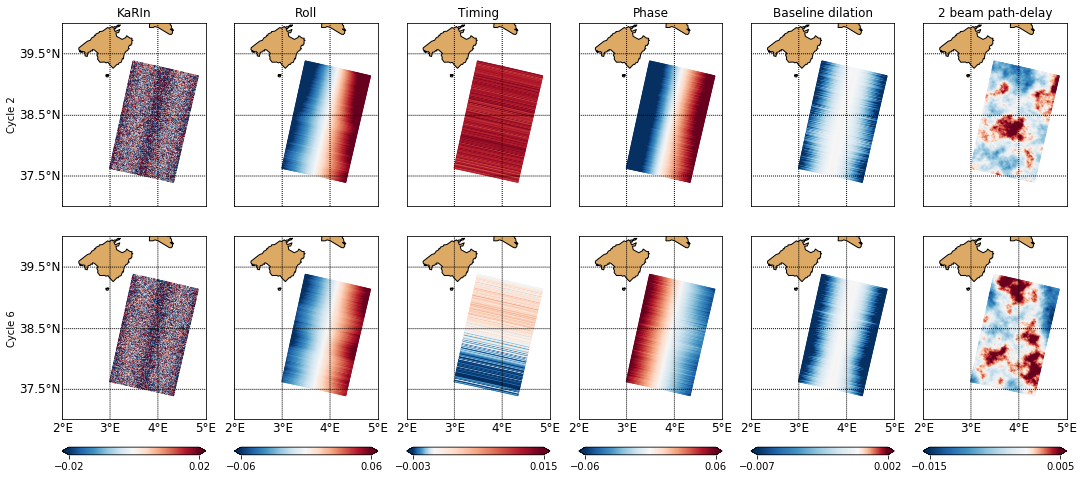

In [12]:
plt.figure(figsize=(18, (3.92*len(ncycles)) + 0.15))

gs = gridspec.GridSpec(len(ncycles)+1, 6, height_ratios=rh_array)

axkc2 = plt.subplot(gs[0,0])
axrc2 = plt.subplot(gs[0,1])
axtc2 = plt.subplot(gs[0,2])
axpc2 = plt.subplot(gs[0,3])
axbc2 = plt.subplot(gs[0,4])
axwc2 = plt.subplot(gs[0,5])
axkc6 = plt.subplot(gs[1,0])
axrc6 = plt.subplot(gs[1,1])
axtc6 = plt.subplot(gs[1,2])
axpc6 = plt.subplot(gs[1,3])
axbc6 = plt.subplot(gs[1,4])
axwc6 = plt.subplot(gs[1,5])
axkC = plt.subplot(gs[2,0])
axrC = plt.subplot(gs[2,1])
axtC = plt.subplot(gs[2,2])
axpC = plt.subplot(gs[2,3])
axbC = plt.subplot(gs[2,4])
axwC = plt.subplot(gs[2,5])

# Cycle 2:
ppk = plot_map_p09(lon_c2, lat_c2, karin_c2, axkc2, box, vmin=clim_k[0], vmax=clim_k[1], merv = [0,0,0,0]
          , parv = [1,0,0,1], cmap=cmap)

ppr = plot_map_p09(lon_c2, lat_c2, roll_c2, axrc2, box, vmin=clim_r[0], vmax=clim_r[1], merv = [0,0,0,0]
          , parv = [0,0,0,0], cmap=cmap)

ppt = plot_map_p09(lon_c2, lat_c2, timerr_c2, axtc2, box, vmin=clim_t[0], vmax=clim_t[1], merv = [0,0,0,0]
          , parv = [0,0,0,0], cmap=shifted_cmapt)

ppp = plot_map_p09(lon_c2, lat_c2, phas_c2, axpc2, box, vmin=clim_p[0], vmax=clim_p[1], merv = [0,0,0,0]
          , parv = [0,0,0,0], cmap=cmap)

ppb = plot_map_p09(lon_c2, lat_c2, bd_c2, axbc2, box, vmin=clim_b[0], vmax=clim_b[1], merv = [0,0,0,0]
          , parv = [0,0,0,0], cmap=shifted_cmapb)

ppw = plot_map_p09(lon_c2, lat_c2, pd2b_c2, axwc2, box, vmin=clim_w[0], vmax=clim_w[1], merv = [0,0,0,0]
          , parv = [0,0,0,0], cmap=shifted_cmapw)

# Cycle 6:
pp = plot_map_p09(lon_c6, lat_c6, karin_c6, axkc6, box, vmin=clim_k[0], vmax=clim_k[1], merv = [1,0,0,1]
          , parv = [1,0,0,1], cmap=cmap)

pp = plot_map_p09(lon_c6, lat_c6, roll_c6, axrc6, box, vmin=clim_r[0], vmax=clim_r[1], merv = [1,0,0,1]
          , parv = [0,0,0,0], cmap=cmap)

pp = plot_map_p09(lon_c6, lat_c6, timerr_c6, axtc6, box, vmin=clim_t[0], vmax=clim_t[1], merv = [1,0,0,1]
          , parv = [0,0,0,0], cmap=shifted_cmapt)

pp = plot_map_p09(lon_c6, lat_c6, phas_c6, axpc6, box, vmin=clim_p[0], vmax=clim_p[1], merv = [1,0,0,1]
          , parv = [0,0,0,0], cmap=cmap)

pp = plot_map_p09(lon_c6, lat_c6, bd_c6, axbc6, box, vmin=clim_b[0], vmax=clim_b[1], merv = [1,0,0,1]
          , parv = [0,0,0,0], cmap=shifted_cmapb)

pp = plot_map_p09(lon_c6, lat_c6, pd2b_c6, axwc6, box, vmin=clim_w[0], vmax=clim_w[1], merv = [1,0,0,1]
          , parv = [0,0,0,0], cmap=shifted_cmapw)

cbar1 = plt.colorbar(ppk, cax=axkC, orientation='horizontal', extend='both')
cbar2 = plt.colorbar(ppr, cax=axrC, orientation='horizontal', extend='both')
cbar3 = plt.colorbar(ppt, cax=axtC, orientation='horizontal', extend='both')
cbar4 = plt.colorbar(ppp, cax=axpC, orientation='horizontal', extend='both')
cbar5 = plt.colorbar(ppb, cax=axbC, orientation='horizontal', extend='both')
cbar6 = plt.colorbar(ppw, cax=axwC, orientation='horizontal', extend='both')

cbar1.set_ticks([clim_k[0], clim_k[1]]) #, 0.
cbar2.set_ticks([clim_r[0], clim_r[1]])
cbar3.set_ticks([clim_t[0], clim_t[1]])
cbar4.set_ticks([clim_p[0], clim_p[1]])
cbar5.set_ticks([clim_b[0], clim_b[1]])
cbar6.set_ticks([clim_w[0], clim_w[1]])

axkc2.set_title('KaRIn')
axkc2.set_ylabel('Cycle 2', labelpad=45)
axkc6.set_ylabel('Cycle 6', labelpad=45)
axrc2.set_title('Roll')
axtc2.set_title('Timing')
axpc2.set_title('Phase')
axbc2.set_title('Baseline dilation')
axwc2.set_title('2 beam path-delay') # wet troposhere

savename = 'figures/' + 'noise_pass09' + '.png'
plt.savefig(str(savename), bbox_inches='tight')

plt.show()


# Pass 22:

In [13]:
general_filename = 'MED_1km_nogap_JAS12_swotFastPhase_BOX_' 

## Select cycles and pass to plot:

In [14]:
ncycles = [2, 6]
npass = 22

## Loading the data:

In [15]:
for ii in xrange(0, len(ncycles)):
    ncycle = ncycles[ii]

    myfile = datadir + general_filename + 'c' + str(ncycle).zfill(2) + '_p' + str(npass).zfill(3) + '.nc'
    print myfile

    ##====================== Load SWOT data ========================

    xds = xr.open_dataset(myfile, engine='netcdf4', lock=False)
    lon = xds.lon_box
    lat = xds.lat_box
    karin = xds.karin
    roll = xds.rolle
    timerr = xds.timerr
    phas = xds.phase
    bd = xds.bd
    pd = xds.pd
    pd2b = xds.pd2b

    ##================ Converting to masked array ==================

    locals()["lon_c"+str(ncycle)] = lon.to_masked_array()
    locals()["lat_c"+str(ncycle)] = lat.to_masked_array()
    locals()["karin_c"+str(ncycle)] = karin.to_masked_array()
    locals()["roll_c"+str(ncycle)] = roll.to_masked_array()
    locals()["timerr_c"+str(ncycle)] = timerr.to_masked_array()
    locals()["phas_c"+str(ncycle)] = phas.to_masked_array()
    locals()["bd_c"+str(ncycle)] = bd.to_masked_array()
    locals()["pd_c"+str(ncycle)] = pd.to_masked_array()
    locals()["pd2b_c"+str(ncycle)] = pd2b.to_masked_array()

/Users/laura/PhD_private/data/SWOT_box_selections/noise/MED_1km_nogap_JAS12_swotFastPhase_BOX_c02_p022.nc
/Users/laura/PhD_private/data/SWOT_box_selections/noise/MED_1km_nogap_JAS12_swotFastPhase_BOX_c06_p022.nc


## Plots:

### Plotting parameters:

In [16]:
# Colormap:
cmap = plt.cm.RdBu_r

# Geographical region limits:
box = [1., 4., 36.5, 39.5] #lomin, lomax, lamin, lamax

# Subplot height ratio:
rh = floor(98. / len(ncycles)) / 100
rh_array = np.append(np.repeat(rh, repeats=len(ncycles)), 0.02) # 0.01 is the ratio of the colorbar


* Clims:

In [17]:
clim_k   = [-.02, +.02]
clim_r   = [-.06, +.06]
clim_t   = [-3.0e-3, 3.5e-2]
clim_p   = [-.1, +.01]
clim_b   = [-3.0e-3, 6.0e-3]
clim_w  = [-.015, +.01]

In [18]:
midp = 1 - clim_t[1]/(clim_t[1] + abs(clim_t[0]))
shifted_cmapt = shiftedColorMap(cmap, midpoint=midp, name='shifted')

midp = 1 - clim_p[1]/(clim_p[1] + abs(clim_p[0]))
shifted_cmapp = shiftedColorMap(cmap, midpoint=midp, name='shifted')

midp = 1 - clim_b[1]/(clim_b[1] + abs(clim_b[0]))
shifted_cmapb = shiftedColorMap(cmap, midpoint=midp, name='shifted')

midp = 1 - clim_w[1]/(clim_w[1] + abs(clim_w[0]))
shifted_cmapw = shiftedColorMap(cmap, midpoint=midp, name='shifted')


In [19]:
def plot_map_p22(xx, yy, var, ax, box, vmin, vmax, merv, parv, cmap):
    """
    Plots an individual plot of the data using scatter and Basemap.
    Input variables:
    - xx = x-axis variable, in this case, longitude
    - yy = y-axis variable, in this case, latitude
    - var = variable to be plotted
    - ax = axis
    - box = box region of the area wanted to be shown
    , where box is a 1 x 4 array: 
    [minimum_longitude maximum_longitude minimum_latitude maximum_latitude]
    - vmin = minimum value of the colorbar 
    - vmax = maximum value of the colorbar
    - merv = a 1 x 4 array to know if to label and where the meridians
    -- [0 0 0 0] = no labels
    -- [1 0 0 1]
    - parv = like merv, but for the parallels' labels
    - cmap = colormap to be used
    Output variables:
    - pp = plot object
    """
    lomin = box[0]
    lomax = box[1]
    lamin = box[2]
    lamax = box[3]
    
    map = Basemap(llcrnrlon=lomin,llcrnrlat=lamin,urcrnrlon=lomax,urcrnrlat=lamax,
         resolution='i', projection='merc', lat_0 = (lamin+lamax)/2, lon_0 = (lomin+lomax)/2
                  , ax=ax, area_thresh=10)
    map.drawcoastlines()

    map.fillcontinents(color='#ddaa66')
    map.drawmeridians(np.arange(-160, 140, 1), labels=merv, size=12)
    map.drawparallels(np.arange(0., 70., 1), labels=parv, size=12)

    pp = map.scatter(xx, yy, s=2, c=var, linewidth=0, vmin=vmin, vmax=vmax, latlon=True
                     , cmap = cmap)
    pp.set_clim([vmin, vmax])
    
    return pp


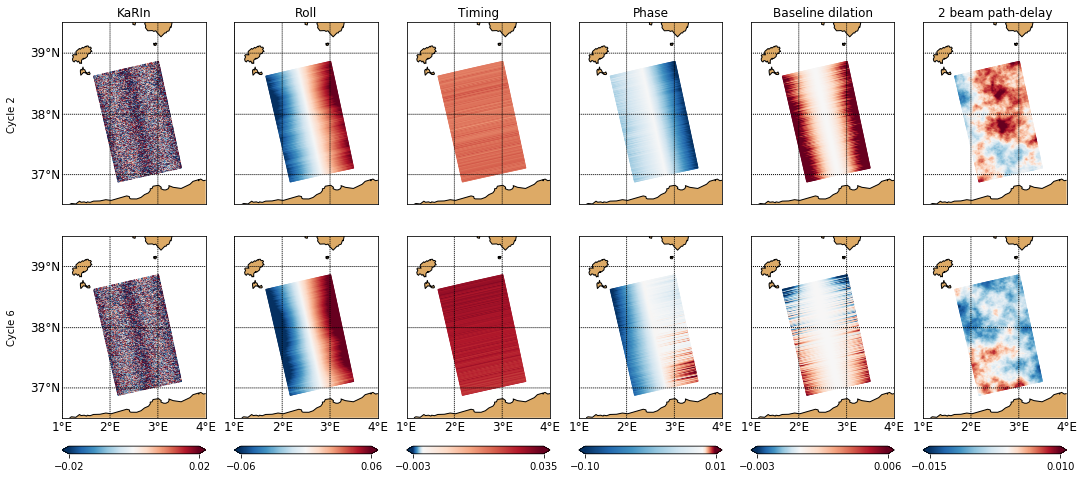

In [20]:
plt.figure(figsize=(18, (3.92*len(ncycles)) + 0.15))

gs = gridspec.GridSpec(len(ncycles)+1, 6, height_ratios=rh_array)

axkc2 = plt.subplot(gs[0,0])
axrc2 = plt.subplot(gs[0,1])
axtc2 = plt.subplot(gs[0,2])
axpc2 = plt.subplot(gs[0,3])
axbc2 = plt.subplot(gs[0,4])
axwc2 = plt.subplot(gs[0,5])
axkc6 = plt.subplot(gs[1,0])
axrc6 = plt.subplot(gs[1,1])
axtc6 = plt.subplot(gs[1,2])
axpc6 = plt.subplot(gs[1,3])
axbc6 = plt.subplot(gs[1,4])
axwc6 = plt.subplot(gs[1,5])
axkC = plt.subplot(gs[2,0])
axrC = plt.subplot(gs[2,1])
axtC = plt.subplot(gs[2,2])
axpC = plt.subplot(gs[2,3])
axbC = plt.subplot(gs[2,4])
axwC = plt.subplot(gs[2,5])

# Cycle 2:
ppk = plot_map_p22(lon_c2, lat_c2, karin_c2, axkc2, box, vmin=clim_k[0], vmax=clim_k[1], merv = [0,0,0,0]
          , parv = [1,0,0,1], cmap=cmap)

ppr = plot_map_p22(lon_c2, lat_c2, roll_c2, axrc2, box, vmin=clim_r[0], vmax=clim_r[1], merv = [0,0,0,0]
          , parv = [0,0,0,0], cmap=cmap)

ppt = plot_map_p22(lon_c2, lat_c2, timerr_c2, axtc2, box, vmin=clim_t[0], vmax=clim_t[1], merv = [0,0,0,0]
          , parv = [0,0,0,0], cmap=shifted_cmapt)

ppp = plot_map_p22(lon_c2, lat_c2, phas_c2, axpc2, box, vmin=clim_p[0], vmax=clim_p[1], merv = [0,0,0,0]
          , parv = [0,0,0,0], cmap=shifted_cmapp)

ppb = plot_map_p22(lon_c2, lat_c2, bd_c2, axbc2, box, vmin=clim_b[0], vmax=clim_b[1], merv = [0,0,0,0]
          , parv = [0,0,0,0], cmap=shifted_cmapb)

ppw = plot_map_p22(lon_c2, lat_c2, pd2b_c2, axwc2, box, vmin=clim_w[0], vmax=clim_w[1], merv = [0,0,0,0]
          , parv = [0,0,0,0], cmap=shifted_cmapw)

# Cycle 6:
pp = plot_map_p22(lon_c6, lat_c6, karin_c6, axkc6, box, vmin=clim_k[0], vmax=clim_k[1], merv = [1,0,0,1]
          , parv = [1,0,0,1], cmap=cmap)

pp = plot_map_p22(lon_c6, lat_c6, roll_c6, axrc6, box, vmin=clim_r[0], vmax=clim_r[1], merv = [1,0,0,1]
          , parv = [0,0,0,0], cmap=cmap)

pp = plot_map_p22(lon_c6, lat_c6, timerr_c6, axtc6, box, vmin=clim_t[0], vmax=clim_t[1], merv = [1,0,0,1]
          , parv = [0,0,0,0], cmap=shifted_cmapt)

pp = plot_map_p22(lon_c6, lat_c6, phas_c6, axpc6, box, vmin=clim_p[0], vmax=clim_p[1], merv = [1,0,0,1]
          , parv = [0,0,0,0], cmap=shifted_cmapp)

pp = plot_map_p22(lon_c6, lat_c6, bd_c6, axbc6, box, vmin=clim_b[0], vmax=clim_b[1], merv = [1,0,0,1]
          , parv = [0,0,0,0], cmap=shifted_cmapb)

pp = plot_map_p22(lon_c6, lat_c6, pd2b_c6, axwc6, box, vmin=clim_w[0], vmax=clim_w[1], merv = [1,0,0,1]
          , parv = [0,0,0,0], cmap=shifted_cmapw)

cbar1 = plt.colorbar(ppk, cax=axkC, orientation='horizontal', extend='both')
cbar2 = plt.colorbar(ppr, cax=axrC, orientation='horizontal', extend='both')
cbar3 = plt.colorbar(ppt, cax=axtC, orientation='horizontal', extend='both')
cbar4 = plt.colorbar(ppp, cax=axpC, orientation='horizontal', extend='both')
cbar5 = plt.colorbar(ppb, cax=axbC, orientation='horizontal', extend='both')
cbar6 = plt.colorbar(ppw, cax=axwC, orientation='horizontal', extend='both')

cbar1.set_ticks([clim_k[0], clim_k[1]]) #, 0.
cbar2.set_ticks([clim_r[0], clim_r[1]])
cbar3.set_ticks([clim_t[0], clim_t[1]])
cbar4.set_ticks([clim_p[0], clim_p[1]])
cbar5.set_ticks([clim_b[0], clim_b[1]])
cbar6.set_ticks([clim_w[0], clim_w[1]])

axkc2.set_title('KaRIn')
axkc2.set_ylabel('Cycle 2', labelpad=45)
axkc6.set_ylabel('Cycle 6', labelpad=45)
axrc2.set_title('Roll')
axtc2.set_title('Timing')
axpc2.set_title('Phase')
axbc2.set_title('Baseline dilation')
axwc2.set_title('2 beam path-delay') # wet troposhere

savename = 'figures/' + 'noise_pass22' + '.png'
plt.savefig(str(savename), bbox_inches='tight')

plt.show()
